# Prerequisites

In [ ]:
!pip install tensorflow scikit-learn matplotlib seaborn opencv-python
import kagglehub
path = kagglehub.dataset_download('samuelcortinhas/apples-or-tomatoes-image-classification')
print("Path to dataset files:", path)
print('Data source import complete.')

100%|██████████| 2.33M/2.33M [00:00<00:00, 2.84MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/samuelcortinhas/apples-or-tomatoes-image-classification/versions/1
Data source import complete.


In [ ]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical

# Paths
BASE_PATH = "/root/.cache/kagglehub/datasets/samuelcortinhas/apples-or-tomatoes-image-classification/versions/1"
TRAIN_DIR = os.path.join(BASE_PATH, "train")
TEST_DIR = os.path.join(BASE_PATH, "test")
CATEGORIES = ['apples', 'tomatoes']

# Load Dataset

In [ ]:
def load_images(folder_path, img_size=64, gray=False):
    X, y = [], []
    for label, category in enumerate(CATEGORIES):
        path = os.path.join(folder_path, category)
        for file in os.listdir(path):
            file_path = os.path.join(path, file)
            img = cv2.imread(file_path)
            if img is None:
                continue
            img = cv2.resize(img, (img_size, img_size))
            if gray:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                img = np.expand_dims(img, axis=-1)
            else:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            X.append(img / 255.0)
            y.append(label)
    return np.array(X), np.array(y)

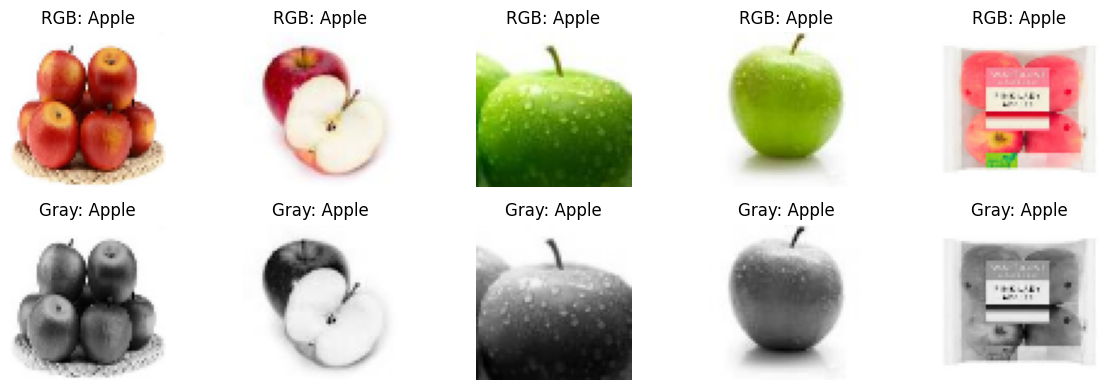

In [ ]:
def show_sample_images(X_rgb, y_rgb, X_gray, y_gray, class_names=["Apple", "Tomato"], num_samples=5):
    plt.figure(figsize=(12, 4))

    for i in range(num_samples):
        # RGB image
        plt.subplot(2, num_samples, i + 1)
        plt.imshow(X_rgb[i])
        plt.title(f"RGB: {class_names[y_rgb[i]]}")
        plt.axis('off')

        # Grayscale image
        plt.subplot(2, num_samples, i + 1 + num_samples)
        plt.imshow(X_gray[i].squeeze(), cmap='gray')
        plt.title(f"Gray: {class_names[y_gray[i]]}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Call the function
show_sample_images(X_train_rgb, y_train_rgb, X_train_gray, y_train_gray)

# CNN Model Creation

In [ ]:
def create_cnn(input_shape):
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        MaxPooling2D(),
        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D(),
        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(2, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

## Model builder

In [ ]:
def create_cnn(input_shape):
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        MaxPooling2D(),
        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D(),
        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(2, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# RBG Factor

In [ ]:
# 1. Load data - RGB
X_train_rgb, y_train_rgb = load_images(TRAIN_DIR, gray=False)
X_test_rgb, y_test_rgb = load_images(TEST_DIR, gray=False)
y_train_rgb_cat = to_categorical(y_train_rgb, 2)
y_test_rgb_cat = to_categorical(y_test_rgb, 2)

# 1. Train RGB model
model_rgb = create_cnn(X_train_rgb.shape[1:])
history_rgb = model_rgb.fit(
    X_train_rgb, y_train_rgb_cat,
    epochs=10, batch_size=32,
    validation_data=(X_test_rgb, y_test_rgb_cat)
)

# 3. Evaluate RGB
y_pred_rgb_prob = model_rgb.predict(X_test_rgb)
y_pred_rgb = np.argmax(y_pred_rgb_prob, axis=1)

# 4. RGB metrics
cm_rgb = confusion_matrix(y_test_rgb, y_pred_rgb)
print("RGB Classification Report:\n", classification_report(y_test_rgb, y_pred_rgb, target_names=["Apple", "Tomato"]))

# 5. RGB ROC
fpr_rgb, tpr_rgb, _ = roc_curve(y_test_rgb, y_pred_rgb_prob[:, 1])
roc_auc_rgb = auc(fpr_rgb, tpr_rgb)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 175ms/step - accuracy: 0.4609 - loss: 1.0475 - val_accuracy: 0.5464 - val_loss: 0.6916
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 0.5911 - loss: 0.6809 - val_accuracy: 0.5464 - val_loss: 0.6981
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step - accuracy: 0.5744 - loss: 0.6611 - val_accuracy: 0.5979 - val_loss: 0.6432
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 184ms/step - accuracy: 0.6705 - loss: 0.5958 - val_accuracy: 0.6598 - val_loss: 0.6182
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 219ms/step - accuracy: 0.7514 - loss: 0.5594 - val_accuracy: 0.6907 - val_loss: 0.5761
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 142ms/step - accuracy: 0.7191 - loss: 0.5774 - val_accuracy: 0.6495 - val_loss: 0.5963
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 153ms/step - accuracy: 0.7108 - loss: 0.5443 - val_accuracy: 0.6907 - val_loss: 0.5477
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - accuracy: 0.7691 - loss: 0.5060 - val_accuracy: 0.

# Grayscale Factor

In [ ]:
# 1. Load data - Grayscale
X_train_gray, y_train_gray = load_images(TRAIN_DIR, gray=True)
X_test_gray, y_test_gray = load_images(TEST_DIR, gray=True)
y_train_gray_cat = to_categorical(y_train_gray, 2)
y_test_gray_cat = to_categorical(y_test_gray, 2)

# 2. Train Grayscale model
model_gray = create_cnn(X_train_gray.shape[1:])
history_gray = model_gray.fit(
    X_train_gray, y_train_gray_cat,
    epochs=10, batch_size=32,
    validation_data=(X_test_gray, y_test_gray_cat)
)

# 3. Evaluate Grayscale
y_pred_gray_prob = model_gray.predict(X_test_gray)
y_pred_gray = np.argmax(y_pred_gray_prob, axis=1)

# 4. Grayscale metrics
cm_gray = confusion_matrix(y_test_gray, y_pred_gray)
print("Grayscale Classification Report:\n", classification_report(y_test_gray, y_pred_gray, target_names=["Apple", "Tomato"]))

# 5. Grayscale ROC
fpr_gray, tpr_gray, _ = roc_curve(y_test_gray, y_pred_gray_prob[:, 1])
roc_auc_gray = auc(fpr_gray, tpr_gray)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 511ms/step - accuracy: 0.5108 - loss: 0.8360 - val_accuracy: 0.5567 - val_loss: 0.6800
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 136ms/step - accuracy: 0.5840 - loss: 0.6764 - val_accuracy: 0.6598 - val_loss: 0.6742
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 167ms/step - accuracy: 0.6488 - loss: 0.6695 - val_accuracy: 0.6186 - val_loss: 0.6412
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 152ms/step - accuracy: 0.6582 - loss: 0.6342 - val_accuracy: 0.6907 - val_loss: 0.6134
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 142ms/step - accuracy: 0.7020 - loss: 0.5984 - val_accuracy: 0.6598 - val_loss: 0.6061
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step - accuracy: 0.7024 - loss: 0.5736 - val_accuracy: 0.6495 - val_loss: 0.6022
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 0.7468 - loss: 0.5402 - val_accuracy: 0.7010 - val_loss: 0.5659
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step - accuracy: 0.7476 - loss: 0.5106 - val_accuracy: 0.6804 - val_

# Confusion Matrix

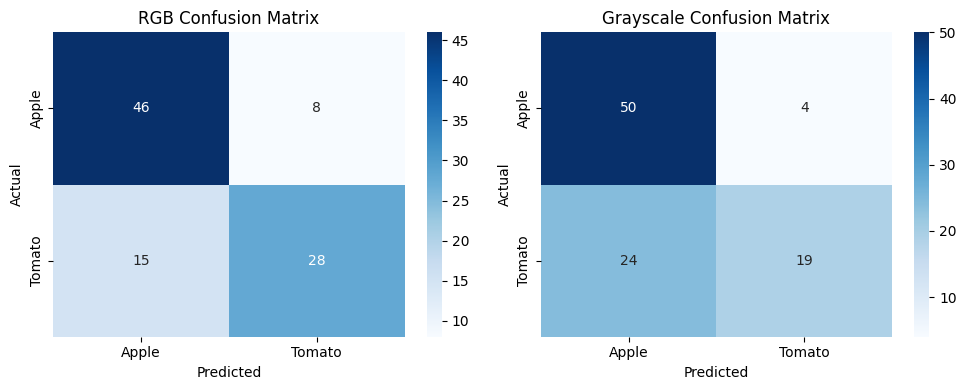

In [ ]:
def plot_conf_matrix(cm, title, ax):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Apple", "Tomato"], yticklabels=["Apple", "Tomato"], ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

plot_conf_matrix(cm_rgb, "RGB Confusion Matrix", axes[0])
plot_conf_matrix(cm_gray, "Grayscale Confusion Matrix", axes[1])
plt.tight_layout()
plt.show()

# ROC Curve

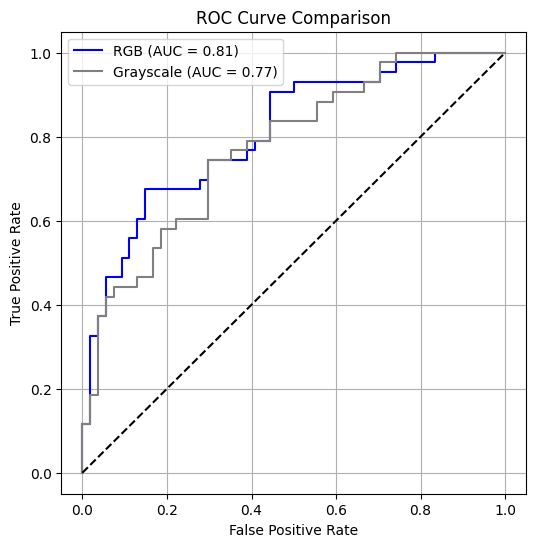

In [ ]:
plt.figure(figsize=(6,6))
plt.plot(fpr_rgb, tpr_rgb, label='RGB (AUC = {:.2f})'.format(roc_auc_rgb), color='blue')
plt.plot(fpr_gray, tpr_gray, label='Grayscale (AUC = {:.2f})'.format(roc_auc_gray), color='gray')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve Comparison')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid()
plt.show()

# Learning Curve

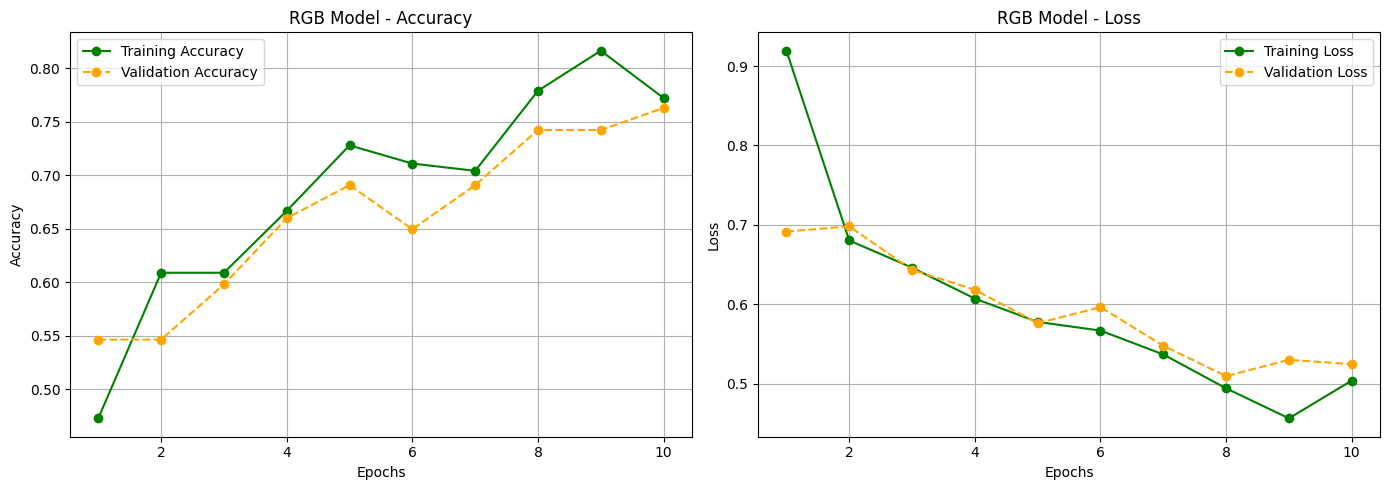

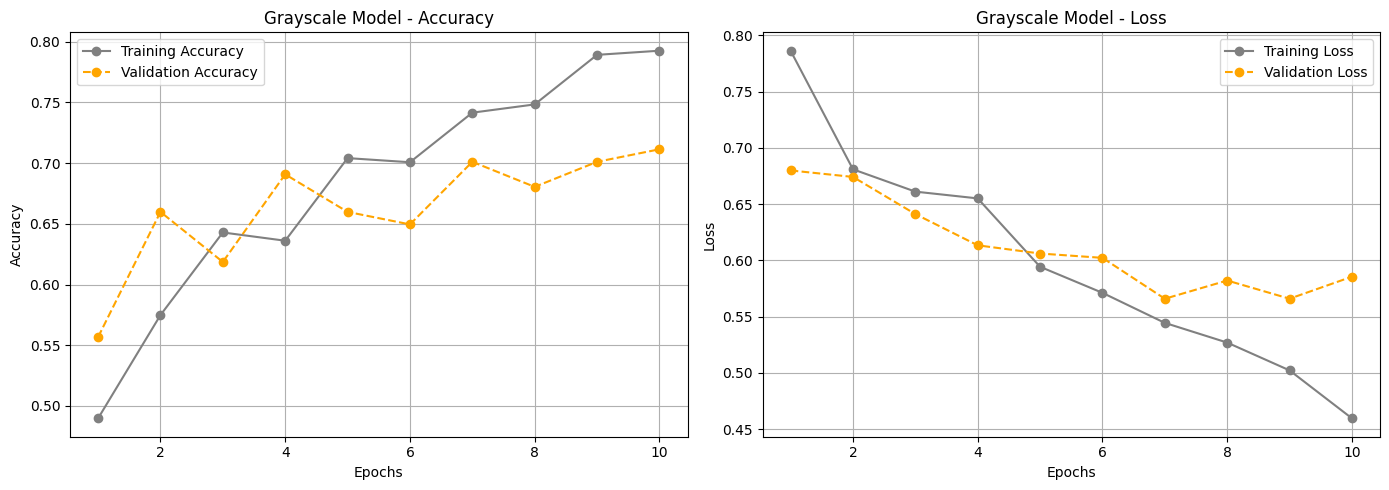

In [ ]:
def plot_learning_curve(history, title='Model Learning Curve', color='blue'):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))

    # Accuracy curve
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'o-', label='Training Accuracy', color=color)
    plt.plot(epochs, val_acc, 'o--', label='Validation Accuracy', color='orange')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()

    # Loss curve
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'o-', label='Training Loss', color=color)
    plt.plot(epochs, val_loss, 'o--', label='Validation Loss', color='orange')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

# Plot for RGB
plot_learning_curve(history_rgb, title="RGB Model", color='green')

# Plot for Grayscale
plot_learning_curve(history_gray, title="Grayscale Model", color='gray')

# Accuracy comparison

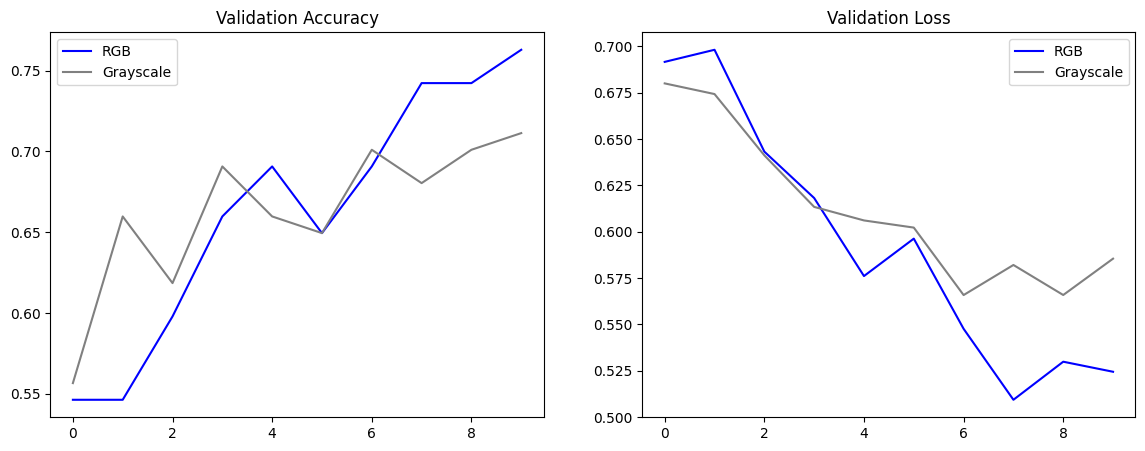

In [ ]:
def plot_comparison(rgb_hist, gray_hist):
    plt.figure(figsize=(14,5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(rgb_hist.history['val_accuracy'], label='RGB', color='blue')
    plt.plot(gray_hist.history['val_accuracy'], label='Grayscale', color='gray')
    plt.title('Validation Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(rgb_hist.history['val_loss'], label='RGB', color='blue')
    plt.plot(gray_hist.history['val_loss'], label='Grayscale', color='gray')
    plt.title('Validation Loss')
    plt.legend()

    plt.show()

plot_comparison(history_rgb, history_gray)

In [ ]:
from sklearn.metrics import classification_report

# RGB Classification Report
print("\nRGB Classification Report:\n")
print(classification_report(
    y_test_rgb,
    y_pred_rgb,
    target_names=["Apple", "Tomato"]
))

# Grayscale Classification Report
print("\nGrayscale Classification Report:\n")
print(classification_report(
    y_test_gray,
    y_pred_gray,
    target_names=["Apple", "Tomato"]
))


RGB Classification Report:

              precision    recall  f1-score   support

       Apple       0.75      0.85      0.80        54
      Tomato       0.78      0.65      0.71        43

    accuracy                           0.76        97
   macro avg       0.77      0.75      0.75        97
weighted avg       0.76      0.76      0.76        97


Grayscale Classification Report:

              precision    recall  f1-score   support

       Apple       0.68      0.93      0.78        54
      Tomato       0.83      0.44      0.58        43

    accuracy                           0.71        97
   macro avg       0.75      0.68      0.68        97
weighted avg       0.74      0.71      0.69        97



# Predict and visualize random samples

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


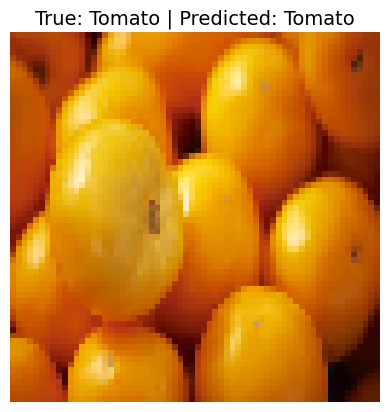

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


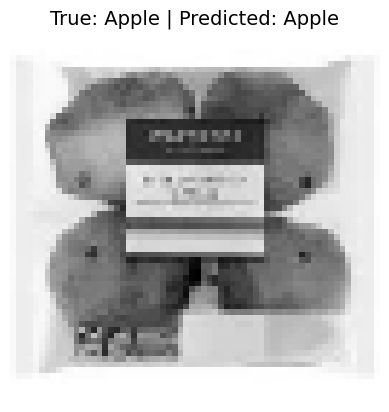

In [ ]:
def predict_random_sample(X, y, model, class_names=["Apple", "Tomato"], gray=False):
    idx = np.random.randint(0, len(X))
    img = X[idx]
    true_label = class_names[y[idx]]
    pred_prob = model.predict(np.expand_dims(img, axis=0))[0]
    pred_label = class_names[np.argmax(pred_prob)]

    if gray:
        plt.imshow(img.squeeze(), cmap='gray')
    else:
        plt.imshow(img)
    plt.axis('off')
    plt.title(f"True: {true_label} | Predicted: {pred_label}", fontsize=14)
    plt.show()
# Predict random from both
predict_random_sample(X_test_rgb, y_test_rgb, model_rgb, gray=False)
predict_random_sample(X_test_gray, y_test_gray, model_gray, gray=True)

Saving apple.jpeg to apple (2).jpeg


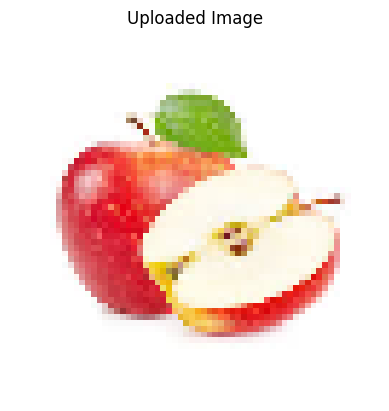

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Prediction: Apple (Confidence: 0.74)


In [ ]:
from google.colab import files
uploaded = files.upload()

for fn in uploaded.keys():
    path = fn
    img = cv2.imread(path)
    img = cv2.resize(img, (64, 64))
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.title("Uploaded Image")
    plt.axis('off')
    plt.show()

    pred = model_rgb.predict(np.expand_dims(img_rgb / 255.0, axis=0))[0]
    class_names = ["Apple", "Tomato"]
    print(f"Prediction: {class_names[np.argmax(pred)]} (Confidence: {np.max(pred):.2f})")